# 수요량 예측 평가

## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import tensorflow.keras as keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM
from keras.backend import clear_session

### 2) 데이터 로딩

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand_simple.csv")
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,sales,tot_sales,weekday,month,y
0,2013-01-01,65,388,1,1,53.0
1,2013-01-02,71,371,2,1,68.0
2,2013-01-03,53,434,3,1,77.0
3,2013-01-04,68,465,4,1,79.0
4,2013-01-05,77,527,5,1,44.0


* 변수 설명

|	칼럼명	|	설명	|
|	-----	|	-----	|
|	date	|	날짜	|
|	sales	|	A매장 B품목의 판매량	|
|	tot_sales	|	회사 전체 B품목의 판매량 |
|	weekday	|	주(1~53) |
|	month	|	월 |
|	y	|	2일후 판매량 |


In [4]:
data.shape

(1824, 6)

### 3) 필요 함수 생성

* 2차원 --> 3차원 구조로 변환

In [5]:
def temporalize(X, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(X) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(X[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

## 2.데이터 탐색

* 전 기간 판매량 그래프

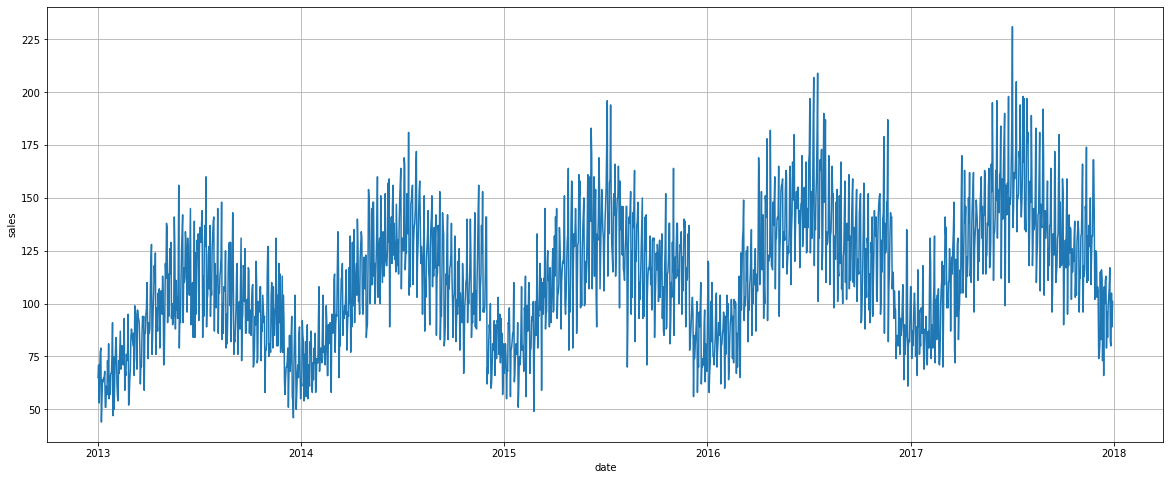

In [6]:
plt.figure(figsize = (20,8))
sns.lineplot('date', 'sales', data = data)
plt.grid()
plt.show()

* 4주간의 판매량 그래프

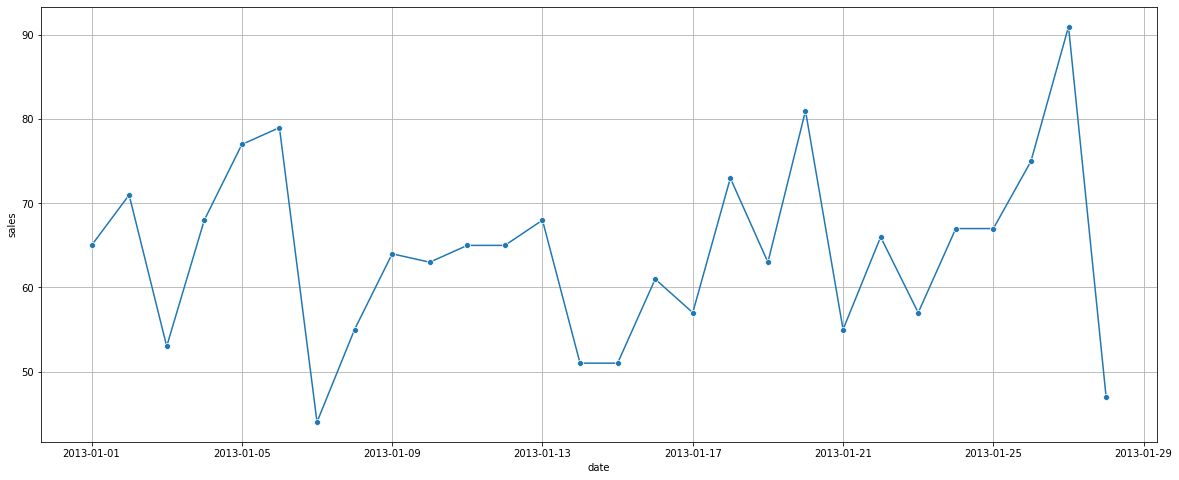

In [7]:
temp = data[:28]
plt.figure(figsize = (20,8))
sns.lineplot('date', 'sales', data = temp, marker = 'o')
plt.grid()
plt.show()

## 3.데이터 준비


### 1) 불필요한 변수 제거

In [8]:
# datetime 제거
drop_cols = ['date']
data.drop(drop_cols, axis = 1, inplace = True)

### 2) 가변수화

In [9]:
data2 = pd.get_dummies(data, columns = ['weekday','month'])

### 3) 데이터 분할

* x, y 분할

In [10]:
target = 'y'
x = data2.drop(target, axis = 1)
y = data2[[target]]

In [11]:
x.shape, y.shape

((1824, 21), (1824, 1))

* train, validation 분할

In [12]:
# 최근 60일 : validation set, 나머지 : train set
n = 60

# 분석단위 : 10일간의 판매 데이터를 분석해서 이틀 후 판매량 예측
timesteps = 20

x_train, x_val = x[:-1*n], x[(-1*n - timesteps+1):]
y_train, y_val = y[:-1*n], y[(-1*n - timesteps+1):]

In [13]:
x_train.shape, y_train.shape

((1764, 21), (1764, 1))

In [14]:
x_val.shape, y_val.shape

((79, 21), (79, 1))

### 4) 스케일링

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

In [16]:
scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train)
y_val_s = scaler_y.transform(y_val)

### 5) 3차원 구조로 변환

In [17]:
x_train_s3, y_train_s3 = temporalize(x_train_s, y_train_s, timesteps)
x_val_s3, y_val_s3 = temporalize(x_val_s, y_val_s, timesteps)

In [18]:
x_train_s3.shape, y_train_s3.shape

((1745, 20, 21), (1745, 1))

In [19]:
x_val_s3.shape, y_val_s3.shape

((60, 20, 21), (60, 1))

## 4.모델링
* 시계열 예측을 위한 LSTM 모델링 수행

### 1) 모델 구조

In [20]:
nfeatures = x_train_s3.shape[2]

In [21]:
clear_session() 

model = Sequential([
    LSTM(32, input_shape=[timesteps, nfeatures], return_sequences = True),
    LSTM(8, return_sequences = False),
    Dense(8, activation="relu"),
    Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            6912      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1312      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,305
Trainable params: 8,305
Non-trainable params: 0
_________________________________________________________________


### 2) 컴파일 및 학습

In [22]:
model.compile(optimizer= 'adam', loss='mse')
history = model.fit(x_train_s3, y_train_s3, 
                    epochs=40, batch_size = 64,
                    validation_split=.2, ).history

Epoch 1/40
22/22 [==============================] - 9s 42ms/step - loss: 0.0572 - val_loss: 0.0164
Epoch 2/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 3/40
22/22 [==============================] - 0s 9ms/step - loss: 0.0111 - val_loss: 0.0143
Epoch 4/40
22/22 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0141
Epoch 5/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0134
Epoch 6/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0118
Epoch 7/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0129
Epoch 8/40
22/22 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 9/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 10/40
22/22 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 11/40
22/22 

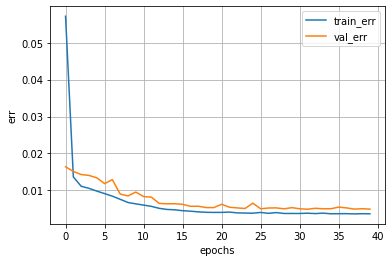

In [23]:
plt.plot(history['loss'], label = 'train_err')
plt.plot(history['val_loss'], label = 'val_err')

plt.xlabel('epochs')
plt.ylabel('err')
plt.legend()
plt.grid()
plt.show()

### 2) 예측 및 평가
* validation set으로 예측하고 평가하시오.

In [24]:
pred = model.predict(x_val_s3)

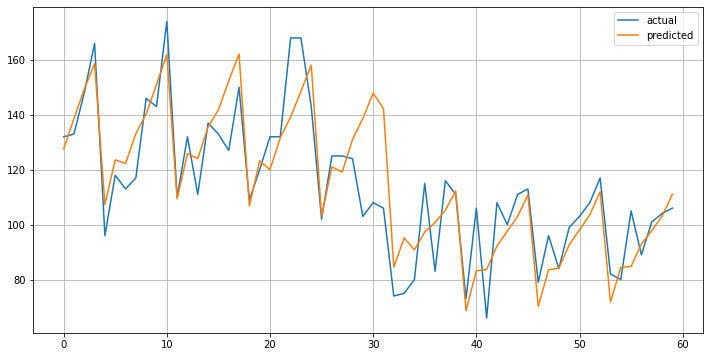

In [25]:
# 판매량으로 환원
y_val_r = scaler_y.inverse_transform(y_val_s3)
pred_r = scaler_y.inverse_transform(pred)

# 실판매량과 예측 판매량 비교 그래프
plt.figure(figsize = (12,6))
plt.plot(y_val_r, label = 'actual')
plt.plot(pred_r, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

* MAE

In [26]:
mean_absolute_error(y_val_r, pred_r)

10.282693990071614

* 정확도(1-MAPE)

In [27]:
1- mean_absolute_percentage_error(y_val_r, pred_r)

0.9049486797072269

## 5.비즈니스 기대가치 평가
* 회귀모델에 대한 비즈니스 평가는 일반화하기 쉽지 않습니다.
* 예측결과를 가지고 현장에서 어떤 Action이 있는지 파악하고, 그에 맞게 평가 체계를 만들어야 합니다.
* 여기서는 시계열 데이터 임을 감안하여 평가를 수행해 보도록 하겠습니다.

### 1) 재고 시뮬레이터

In [28]:
def inv_simulator(y, pred, safe_stock) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})
    
    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 2일후 판매 예측량에 기초하므로 계산을 위해 마지막 2행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로, 
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음. 
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고
        
        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)
        
        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()

    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory, AvgDailyStock, turnover,lost_sum

### 2) 예측 결과 시뮬레이션

In [29]:
result, AvgDailyStock , turnover , lost_sum = inv_simulator(y_val_r, pred_r, 30)

일평균 재고량     : 89.379
일평균 재고회전율 : 1.37
기회손실 수량     : -93.0


In [30]:
result.tail()

,y,pred,base_stock,close_stock,order,receive,lost
53,82.0,72.0,115,33,82.0,99,0.0
54,80.0,84.0,131,51,72.0,98,0.0
55,105.0,85.0,133,28,100.0,82,0.0
56,89.0,93.0,100,11,122.0,72,0.0
57,101.0,98.0,111,10,131.0,100,0.0


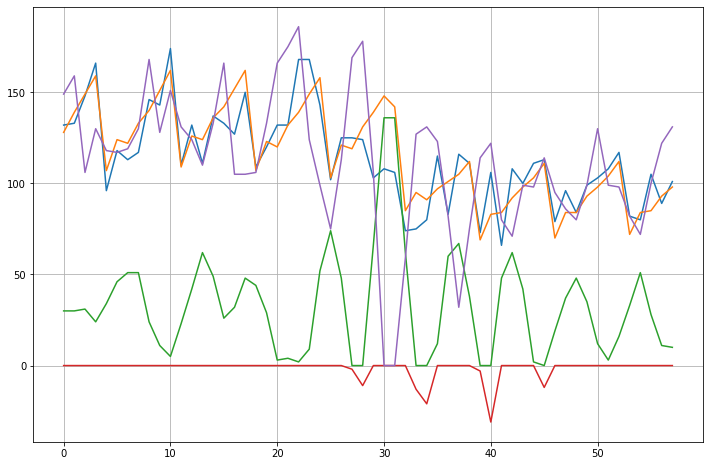

In [31]:
plt.figure(figsize = (12,8))
plt.plot(result['y'])
plt.plot(result['pred'])
plt.plot(result['close_stock'])
plt.plot(result['lost'])
plt.plot(result['order'])

plt.grid()
plt.show()

## 6.실습: 
* 모델을 개선하고 재고회전율로 평가해 봅시다.
